In [2]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np
import json
import os

In [4]:
import sys
sys.path.append("../scripts/")

In [5]:
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import proccutit


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

## Reading results

In [6]:
#os.listdir('../scripts/results')

In [7]:
def get_results_json(file_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(parent_directory, 'scripts/results')
    #print("Path to results", target_directory)

    #file_name = 'test.json'
    file_path = os.path.join(target_directory, file_name)
    #print(file_path)

    with open(file_path) as json_file:
        data = json.load(json_file)

    df = pd.DataFrame(data)
    #print(df)
    return df

In [8]:
results_df = get_results_json('test_mrs2.json')

In [9]:
def got_correct(df, prompt):
    doc_percentage_correct = {}

    for d in df.doc_id.unique():
        doc_preds = df[df.doc_id == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        #print(doc_preds)

        # For sensitive docs
        #doc_preds = doc_preds[doc_preds.ground_truth == 0]
        #if len(doc_preds) == 0:
        #    continue

        doc_correct = 0
        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth:
                doc_correct += 1

        doc_correct_avg = doc_correct / len(doc_preds)
        doc_percentage_correct[d] = doc_correct_avg

    return doc_percentage_correct



prompt = 'itspersonal'
doc_percentage_correct = got_correct(results_df, prompt)
x = list(doc_percentage_correct.values())

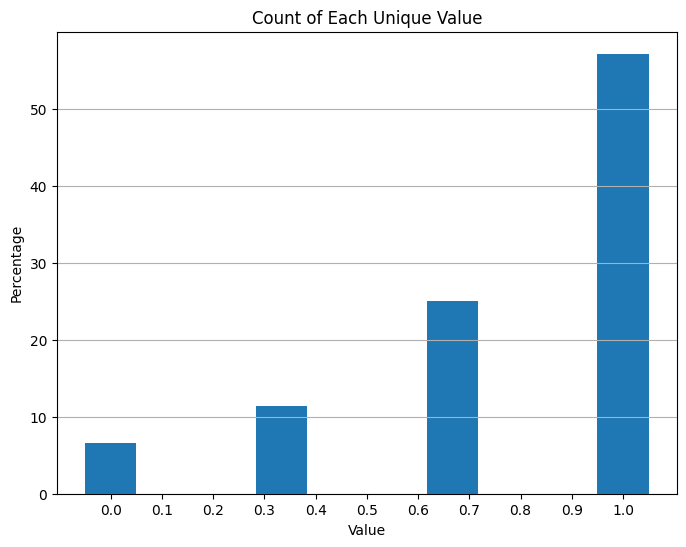

In [10]:
data = x
unique_values, counts = np.unique(data, return_counts=True)
total_count = len(data)
percentages = (counts / total_count) * 100

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(unique_values, percentages, width=0.1)
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Count of Each Unique Value')
plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks to show the range 0.0 - 1.0
plt.grid(axis='y')
plt.show()


In [11]:
def confusion_scores(df, prompt):
    doc_percentage_correct = {}

    for d in df.model.unique():

        doc_preds = df[df.model == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        TP, TN, FP, FN = 0, 0, 0, 0

        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth and row.ground_truth == 1:
                TP += 1
            elif row.prediction == row.ground_truth and row.ground_truth == 0:
                TN += 1
            elif row.prediction != row.ground_truth and row.ground_truth == 1:
                FN += 1
            else:
                FP += 1

        scores = [TP, TN, FP, FN]
        doc_percentage_correct[d] = scores

    return doc_percentage_correct


prompt = 'itspersonal'
model_confusion = confusion_scores(results_df, prompt)

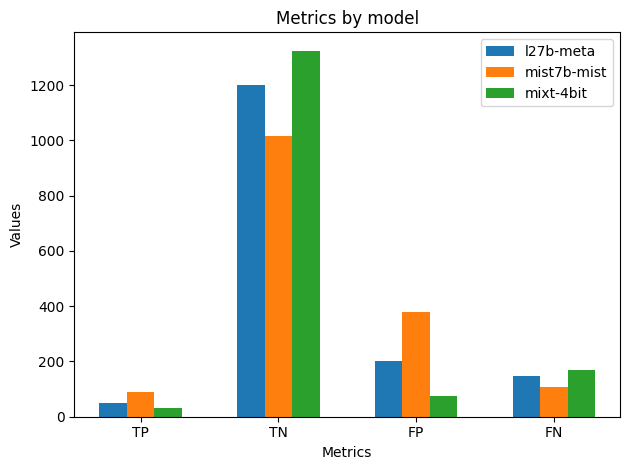

In [12]:
data = model_confusion
labels = ['TP', 'TN', 'FP', 'FN']
models = list(data.keys())
values = np.array(list(data.values()))

# Number of groups and bar width
n_groups = len(labels)
bar_width = 0.2

# Set position of bar on X axis
r = np.arange(len(labels))
positions = [r + bar_width*i for i in range(len(models))]

# Make bars
for pos, model in zip(positions, models):
    plt.bar(pos, values[models.index(model)], width=bar_width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics by model')
plt.xticks([r + bar_width for r in range(n_groups)], labels)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
results_df.keys()

Index(['model', 'prompt', 'doc_id', 'prediction', 'ground_truth'], dtype='object')

#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [14]:
from sklearn.metrics import balanced_accuracy_score

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='balanced_accuracy')
    # Merge results into a single DataFrame - easy comparison
    performance_df = pd.merge(accuracy_df, balanced_accuracy_df, on=['model', 'prompt'])
    #print(performance_df)
    return performance_df

prompt_performance_df = prompt_performance(results_df)

In [15]:
prompt_performance_df

,model,prompt,accuracy,balanced_accuracy
0,l27b-meta,itspersonal,0.782854,0.557359
1,l27b-meta,itspersonal_2,0.799750,0.517136
2,l27b-meta,itspersonalfewshot,0.178348,0.513727
3,mist7b-mist,itspersonal,0.694969,0.592748
4,mist7b-mist,itspersonal_2,0.655542,0.579719
5,mist7b-mist,itspersonalfewshot,0.419900,0.554019
6,mixt-4bit,itspersonal,0.847935,0.548972
7,mixt-4bit,itspersonal_2,0.806633,0.562258


Interaction effects: we aim to assess interaction effects between models and prompts. An ANOVA (Analysis of Variance) if data meets the is parametric.

Incomplete

In [16]:
l2_mist = prompt_performance_df
l2_mist = l2_mist.drop([6, 7])
l2_mist

,model,prompt,accuracy,balanced_accuracy
0,l27b-meta,itspersonal,0.782854,0.557359
1,l27b-meta,itspersonal_2,0.799750,0.517136
2,l27b-meta,itspersonalfewshot,0.178348,0.513727
3,mist7b-mist,itspersonal,0.694969,0.592748
4,mist7b-mist,itspersonal_2,0.655542,0.579719
5,mist7b-mist,itspersonalfewshot,0.419900,0.554019


In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


l2_mist['model'] = l2_mist['model'].astype(str)
l2_mist['prompt'] = l2_mist['prompt'].astype(str)
# Model with interaction between 'model' and 'prompt'
model = smf.ols('accuracy ~ model * prompt', data=l2_mist).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 28 Feb 2024   Prob (F-statistic):                nan
Time:                        11:08:29   Log-Likelihood:                 203.58
No. Observations:                   6   AIC:                            -395.2
Df Residuals:                       0   BIC:                            -396.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [18]:
from scipy.stats import kruskal

data1 = l2_mist[l2_mist['model'] == 'l27b-meta']['accuracy']
data2 = l2_mist[l2_mist['model'] == 'mist7b-mist']['accuracy']
#data3 = results_df[results_df['model'] == 'mixt4bit']['accuracy']

# Kruskal-Wallis H Test
stat, p = kruskal(data1, data2) #, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


Statistics=0.429, p=0.513
Same distributions (fail to reject H0)


#### Document Difficulty

Identify difficult documents to classify. We calculate the misclassification rate for each document across all models and prompts.

We find documents that no model-prompt combination could predict this correctly.

In [19]:
df = results_df
misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
# Sorting finds the documents with the highest misclassification rates
most_difficult_docs = misclassification_df.sort_values(by='misclassification_rate', ascending=False)


In [20]:
# Documents entirely misclassified
most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

,doc_id,misclassification_rate
1473,54611,1.0
1474,54612,1.0
1520,54662,1.0
1411,54546,1.0
1522,54664,1.0
1290,230660,1.0
934,175702,1.0


Next, we analyse these errors. We will manually review the documents, their predicted and ground truths.

In [21]:
# Top 10 most difficult documents
difficult_doc_ids = most_difficult_docs['doc_id'].head(10)
difficult_docs = df[df['doc_id'].isin(difficult_doc_ids)]
difficult_docs

,model,prompt,doc_id,prediction,ground_truth
187,l27b-meta,itspersonal,230660,1,0
190,l27b-meta,itspersonal,54546,0,1
194,l27b-meta,itspersonal,54554,0,1
201,l27b-meta,itspersonal,54611,0,1
672,l27b-meta,itspersonal,175451,0,0
...,...,...,...,...,...
12034,mixt-4bit,itspersonal_2,54662,0,1
12035,mixt-4bit,itspersonal_2,54664,0,1
12238,mixt-4bit,itspersonal_2,54555,0,1
12267,mixt-4bit,itspersonal_2,54612,0,1


In [22]:
difficult_docs.index

Index([  187,   190,   194,   201,   672,   866,   867,  1070,  1099,  1322,
        1785,  1788,  1792,  1799,  2270,  2464,  2465,  2668,  2697,  2920,
        3383,  3386,  3390,  3397,  3868,  4062,  4063,  4266,  4295,  4518,
        4981,  4984,  4988,  4995,  5463,  5656,  5657,  5857,  5886,  6108,
        6570,  6573,  6577,  6584,  7053,  7243,  7244,  7446,  7475,  7698,
        8159,  8162,  8166,  8173,  8644,  8838,  8839,  9042,  9071,  9294,
        9757,  9760,  9764,  9771, 10242, 10436, 10437, 10640, 10669, 10892,
       11355, 11358, 11362, 11369, 11840, 12034, 12035, 12238, 12267, 12490],
      dtype='int64')

In [24]:
s = load_sara()
diff_id = list(difficult_doc_ids)

id_index = []
for idd in diff_id:
    find = s[s.doc_id == idd]
    id_index.append(find.index[0])

print(id_index)
x = proccutit(s.loc[id_index])
for hard in x.iterrows():
    print(hard[1].text)
    break

[215, 1176, 900, 203, 901, 200, 1406, 699, 207, 1146]
Gwyn,
Thanks for this msg and other updates.


#### Model Comparison Analysis

We conduct numerous statistical tests.